# Possion equation II

## 构造等参元

Firedrake 中坐标是通过函数 `Function` 给出的, 可以通过更改该函数的值来移动网格或者构造等参元对应的映射.

### 修改网格坐标 (移动网格)

坐标的存储 (numpy 数组)

```python
mesh = RectangleMesh(10, 10, 1, 1)
mesh.coordinates.dat.data
mesh.coordinates.dat.data_ro
mesh.coordinates.dat.data_with_halos
mesh.coordinates.dat.data_ro_with_halos
```

单进程运行时 `data` 和 `data_with_halos` 相同. 关于 `halos` 请参考 https://op2.github.io/PyOP2/mpi.html.

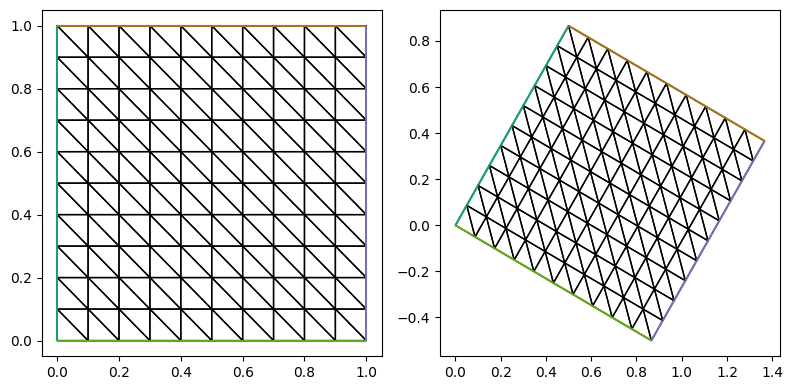

In [1]:
from firedrake import RectangleMesh, triplot
import numpy as np

import matplotlib.pyplot as plt

# test_mesh = UnitDiskMesh(refinement_level=3)
test_mesh = RectangleMesh(10, 10, 1, 1)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
handle = triplot(test_mesh, axes=ax[0])

theta = np.pi/6
R = np.array([[np.cos(theta), - np.sin(theta)], 
              [np.sin(theta),   np.cos(theta)]])

# test_mesh.coordinates.dat.datas[:] = test_mesh.coordinates.dat.data_ro[:]@R
test_mesh.coordinates.dat.data_with_halos[:] = test_mesh.coordinates.dat.data_ro_with_halos[:]@R

handle = triplot(test_mesh, axes=ax[1])
fig.tight_layout()

### 简单映射边界点

等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上. 以单位圆为例:

```python
def points2bdy(points):
    r = np.linalg.norm(points, axis=1).reshape([-1, 1])
    return points/r

def make_high_order_mesh_map_bdy(m, p):
    coords = m.coordinates
    V_p = VectorFunctionSpace(m, 'CG', p)
    coords_p = Function(V_p, name=f'coords_p{i}').interpolate(coords)
    
    bc = DirichletBC(V_p, 0, 'on_boundary')
    points = coords_p.dat.data_ro_with_halos[bc.nodes]
    coords_p.dat.data_with_halos[bc.nodes] = points2bdy(points)
    
    return Mesh(coords_p)
```

### 同时移动边界单元的内点

Reference:

1. [M. Lenior, Optimal Isoparametric Finite Elements and Error Estimates For Domains Involving Curved Boundaries. SIAM. J. Numer. Anal. 23(3). 1986. pp 562--580.](https://epubs.siam.org/doi/10.1137/0723036)


等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上, 同时移动边界单元的内部自由度.

```python
def make_high_order_mesh_simple(m, p):
    if p == 1:
        return m

    coords_1 = m.coordinates
    coords_i = coords_1
    for i in range(2, p+1):
        coords_im1 = coords_i
        V_i = VectorFunctionSpace(m, 'CG', i)
        bc = DirichletBC(V_i, 0, 'on_boundary')
        coords_i = Function(V_i, name=f'coords_p{i}').interpolate(coords_im1)
        coords_i.dat.data_with_halos[bc.nodes] = \
            points2bdy(coords_i.dat.data_ro_with_halos[bc.nodes])

    return Mesh(coords_i)
```

__注__: 
这是一个简单的实现, 并不完全符合文献[1]中等参元映射构造方式, 一个完整的实现方式见文件 [py/make_mesh_circle_in_rect.py](py/make_mesh_circle_in_rect.py) 中的函数 `make_high_order_coords_for_circle_in_rect`: 该函数实现了内部具有一个圆形界面的矩形区域上的等参映射.

### 数值实验

精确解为 $u =  1 - (x^2 + y^2)^{3.5}$

In [2]:
%run py/possion_convergence_circle.py -max_degree 3 -exact "1 - (x[0]**2 + x[1]**2)**3.5"

Exact solution:  1 - (x[0]**2 + x[1]**2)**3.5 

p = 1; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.21472147 0.10953982 0.05505367]
            orders: [0.99748178 1.00490702]
    Rel. L2 errors: [0.02973733 0.00764636 0.00192565]
            orders: [2.01284532 2.01420929]

p = 2; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.02567607 0.00823192 0.00274559]
            orders: [1.68586184 1.60384374]
    Rel. L2 errors: [0.00804638 0.00197793 0.00048968]
            orders: [2.07953304 2.0391775 ]

p = 2; Use iso: True; Only move bdy: False.
    Rel. H1 errors: [0.02049517 0.00516031 0.0012846 ]
            orders: [2.04399704 2.03112667]
    Rel. L2 errors: [1.32436157e-03 1.65779996e-04 2.05806815e-05]
            orders: [3.07968268 3.04739627]

p = 3; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.01465085 0.00517696 0.00182789]
            orders: [1.54172011 1.52063516]
    Rel. L2 errors: [0.00786267 0.00195543 0.00048687]
          

## 间断有限元方法

### UFL 符号
+ `+`:  

    `u('-')`

+ `-`:  

    `u('+')`

+ avg:  

    `(u('+') + u('-'))/2`

+ jump: 
    
    `jump(u, n) = u('+')*n('+') + u('-')*n('-')`
    
    `jump(u) = u('+') - u('-')`

+ FacetNormal:

    边界法向

+ CellDiameter:
    
    网格尺寸

### UFL 测度
1. `ds` 外部边
2. `dS` 内部边

### 变分形式

\begin{equation}
\begin{aligned}
    \int_\Omega \nabla u \cdot \nabla v 
    &- \int_{EI} (\{\nabla u\}[vn] + [un]\{\nabla v\})
     - \frac{\alpha}{h}\int_{EI} [un][vn] \\
    &- \int_{EO} (v n \nabla u  + u n \nabla v)
     - \frac{\alpha}{h}\int_{EO} uv \\
    &- \int_\Omega f v   - \int_{\partial\Omega_N} g_N v = 0
\end{aligned}
\end{equation}
其中 $[vn] = v^+n^+ + v^-n^-, \{u\} = (u^+ + u^-)/2$

In [3]:
from firedrake import *
import matplotlib.pyplot as plt

mesh = RectangleMesh(8, 8, 1, 1)

DG1 = FunctionSpace(mesh, 'DG', 1)
u, v = TrialFunction(DG1), TestFunction(DG1)

x, y = SpatialCoordinate(mesh)
f = sin(pi*x)*sin(pi*y)

h = Constant(2.0)*Circumradius(mesh)
alpha = Constant(1)
gamma = Constant(1)

n = FacetNormal(mesh)

a = inner(grad(u), grad(v))*dx \
  - dot(avg(grad(u)), jump(v, n))*dS \
  - dot(jump(u, n), avg(grad(v)))*dS \
  + alpha/avg(h)*dot(jump(u, n), jump(v, n))*dS \
  - dot(grad(u), v*n)*ds \
  - dot(u*n, grad(v))*ds \
  + gamma/h*u*v*ds

L = f*v*dx

u_h = Function(DG1, name='u_h')
bc = DirichletBC(DG1, 0, 'on_boundary')
solve(a == L, u_h, bcs=bc)

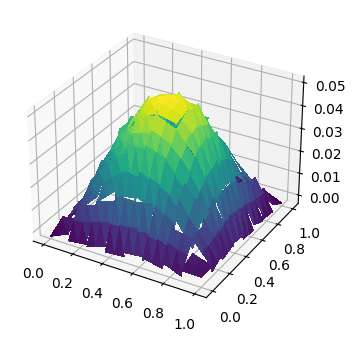

In [4]:
fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(u_h, axes=ax)

### Positive and negative part of inner boundary

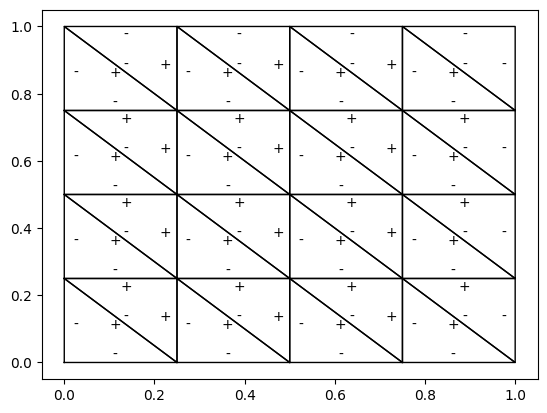

In [5]:
from firedrake import *
from firedrake.petsc import PETSc

import os, sys
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 14})

N = PETSc.Options().getInt('N', default=4)

m = RectangleMesh(N, N, 1, 1)
V = FunctionSpace(m, 'DG', 0)
Vc = VectorFunctionSpace(m, 'DG', 0)
V_e = FunctionSpace(m, 'HDivT', 0)
V_ec = VectorFunctionSpace(m, 'HDivT', 0)

x, y = SpatialCoordinate(m)
u = Function(V, name='u')
uc = Function(Vc).interpolate(m.coordinates)
u_e = Function(V_e, name='u_e')
u_ec = Function(V_ec).interpolate(m.coordinates)

ncell = len(u.dat.data_ro)

factor = 0.7
for i in range(ncell):
    cell = V.cell_node_list[i][0]
    u.dat.data_with_halos[:] = 0
    u.dat.data_with_halos[cell] = 1
    es = V_e.cell_node_list[i]
    cc = uc.dat.data_ro_with_halos[cell, :]
    
    vertex = m.coordinates.dat.data_ro_with_halos[
        m.coordinates.function_space().cell_node_list[i]
    ]
    vertex = np.vstack([vertex, vertex[0]])
    plt.plot(vertex[:, 0], vertex[:, 1], 'k', lw=1)
    
    for e in es:
        u_e.dat.data_with_halos[:] = 0
        u_e.dat.data_with_halos[e] = 1
        ec = u_ec.dat.data_ro_with_halos[e, :]
        dis = ec - cc
        
        v_p, v_m = assemble(u('+')*u_e('+')*dS), assemble(u('-')*u_e('-')*dS)
        _x = cc[0] + factor*dis[0]
        _y = cc[1] + factor*dis[1]

        plt.text(_x, _y, '+' if v_p > 0 else '-', ha='center', va='center')
        
rank, size = m.comm.rank, m.comm.size
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig(f'figures/dgflag_{size}-{rank}.pdf')

## Dirac Delta 函数

### 通过数值积分公式实现 dirac delta 函数

In [6]:
from firedrake import *

from firedrake.petsc import PETSc
from pyop2 import op2
from pyop2.datatypes import ScalarType
from mpi4py import MPI
import finat
import numpy as np

import matplotlib.pyplot as plt

set_level(CRITICAL) # Disbale warnings

class DiracOperator(object):
    def __init__(self, m, x0):
        """Make Dirac delta operator at point

        Args:
            m: mesh
            x0: source point

        Example:
            delta = DiracOperator(m, x0)
            f = Function(V)
            f_x0 = assemble(delta(f))
        """
        self.mesh = m
        self.x0 = x0
        self.operator = None
        
    def __call__(self, f):
        if self.operator is None:
            self._init()
        return self.operator(f)

    def _init(self):
        m = self.mesh
        x0 = self.x0
        V = FunctionSpace(m, 'DG', 0)
        cell_marker = Function(V, name='cell_marker', dtype=ScalarType)
        qrule = finat.quadrature.make_quadrature(V.finat_element.cell, 0)
        cell, X = m.locate_cell_and_reference_coordinate(x0, tolerance=1e-6)

        # c = 0 if X is None else 1
        n_cell_local = len(cell_marker.dat.data)
        if X is not None and cell < n_cell_local:
            c = 1
        else:
            c = 0

        comm = m.comm
        s = comm.size - comm.rank
        n = comm.allreduce(int(s*c), op=MPI.MAX)

        if n == 0:
            raise BaseException("Points not found!")

        k = int(comm.size - n) # get the lower rank which include the point x0

        if c == 1 and comm.rank == k:
            X[X<0] = 0
            X[X>1] = 1
            cell_marker.dat.data[cell] = 1
            comm.bcast(X, root=k)
        else:
            cell_marker.dat.data[:] = 0 # we must set this otherwise the process will hangup
            X = comm.bcast(None, root=k)


        cell_marker.dat.global_to_local_begin(op2.READ)
        cell_marker.dat.global_to_local_end(op2.READ)

        qrule.point_set.points[0] = X
        qrule.weights[0] = qrule.weights[0]/np.real(assemble(cell_marker*dx))

        self.operator = lambda f: f*cell_marker*dx(scheme=qrule)


### 测试 `DiracOperator`

In [7]:
def test_dirca_delta_1D():
    test_mesh = IntervalMesh(8, 1)
    V = FunctionSpace(test_mesh, 'CG', 3)
    x1 = 0.683
    source = Constant([x1,])
    delta = DiracOperator(test_mesh, source)

    x, = SpatialCoordinate(test_mesh)
    g = Function(V).interpolate(x**2)

    expected_value =  g.at([x1])
    value = assemble(delta(g))
    PETSc.Sys.Print(f"value = {value}, expected value = {expected_value}")


test_dirca_delta_1D()

value = 0.46648900000000015, expected value = 0.4664890000000098


/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


In [8]:
def test_dirca_delta_2D():
    test_mesh = RectangleMesh(8, 8, 1, 1)
    V = FunctionSpace(test_mesh, 'CG', 3)
    x1 = 0.683
    x2 = 0.333
    source = Constant([x1,x2])
    x0 = source
    delta = DiracOperator(test_mesh, source)

    x, y = SpatialCoordinate(test_mesh)
    g = Function(V).interpolate(x**3 + y**3)

    expected_value =  g.at([x1, x2])
    value = assemble(delta(g))
    PETSc.Sys.Print(f"value = {value}, expected value = {expected_value}")


test_dirca_delta_2D()

value = 0.3555380240000009, expected value = 0.3555380240000011


/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


### Dirac delta 函数的 L2 投影

/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


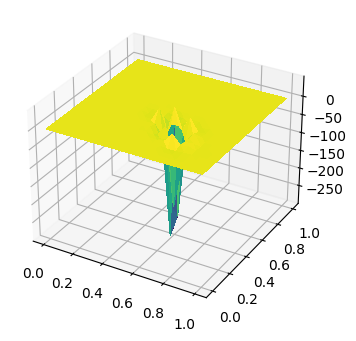

In [9]:
test_mesh = RectangleMesh(10, 10, 1, 1)
V = FunctionSpace(test_mesh, 'CG', 3)
delta = DiracOperator(test_mesh, [0.638, 0.33])
bc = DirichletBC(V, 0, 'on_boundary')
u, v = TrialFunction(V), TestFunction(V)
sol = Function(V)
solve(u*conj(v)*dx == delta(conj(v)), sol, bcs=bc)

fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(sol, axes=ax) # 为什么负值那么大？

### 求解源项为 Dirca delta 函数的 Possion 方程

/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


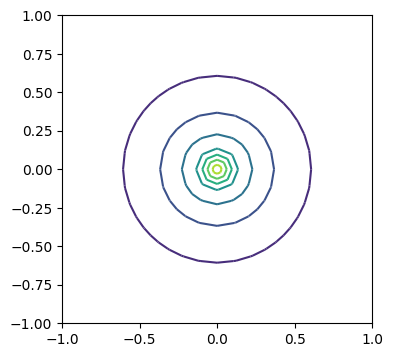

In [10]:
x0 = [0, 0]
# N = 500
# m = SquareMesh(N, N, 1)

m = UnitDiskMesh(refinement_level=3)

V = FunctionSpace(m, 'CG', 1)

v = TestFunction(V)
u = TrialFunction(V)

a = inner(grad(u), grad(v))*dx
L = DiracOperator(m, x0)(v)
u = Function(V, name='u')

bc = DirichletBC(V, 0, 'on_boundary')

solve(a == L, u, bcs=bc)

# solve(a == L, u)
fig, ax = plt.subplots(figsize=[4, 4])
ts = tricontour(u, axes=ax)

## 自由度映射关系

### Cell node map

+ `V.dim()`: Number of dofs
+ `V.cell_node_list`: an array of cell node map (same with `V.cell_node_map().values`)

In [11]:
mesh = RectangleMesh(8, 8, 1, 1)
V = FunctionSpace(mesh, 'CG', 1)

# the global numers of the dofs in the first 2 elements
for i in range(2): 
    print(f"cell {i}: ", V.cell_node_list[i]) 

cell 0:  [0 1 2]
cell 1:  [1 2 3]


__Example: 第一个三角形的坐标__

In [12]:
coords = mesh.coordinates
V_c = coords.function_space()
dof_numbers = V_c.cell_node_list[0]

for i in dof_numbers:
    print(f"vertex {i}:", coords.dat.data_ro_with_halos[i])

vertex 0: [0. 0.]
vertex 1: [0.    0.125]
vertex 2: [0.125 0.   ]


### Finite element (dofs on reference cell)

In [13]:
V = FunctionSpace(mesh, 'CG', 2)
element = V.finat_element

print("cell: ",  element.cell)
print("degree: ", element.degree)

cell:  <FIAT.reference_element.UFCTriangle object at 0x7fa977f5c550>
degree:  2


In [14]:
element.entity_dofs() # dofs for every entity (vertex, edge, face, volume)

{0: {0: [0], 1: [1], 2: [2]}, 1: {0: [3], 1: [4], 2: [5]}, 2: {0: []}}

## Adaptive Finite Element Methods

### Possion on Lshape

File: [](py/adapt_possion.py)


1. 方程求解

   :::{literalinclude} py/adapt_possion.py
   :pyobject: solve_possion
   :::
   
2. 误差估计
   :::{literalinclude} py/adapt_possion.py
   :pyobject: estimate
   :::
   
   :::{literalinclude} py/adapt_possion.py
   :pyobject: assemble_eta_K_py
   :::
   
3. 网格标记

   :::{literalinclude} py/adapt_possion.py
   :pyobject: mark_cells
   :::

使用以上函数以及 `DMPlex` 的 `adaptLabel` 方法, 我们可以写出 L 区域上的网格自适应方法

:::{literalinclude} py/adapt_possion.py
:pyobject: adapt_possion_Lshape
:::


L 型区域上的网格自适应算例

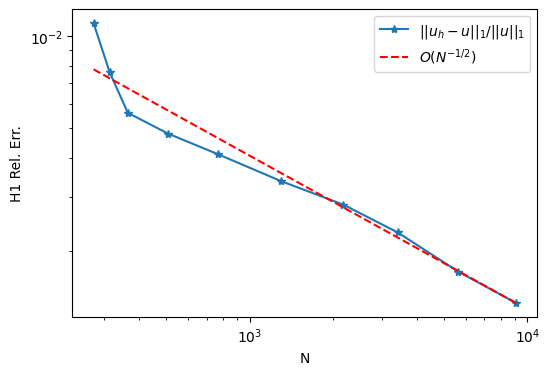

In [15]:
from py.adapt_possion import adapt_possion_Lshape, plot_adapt_result

result = adapt_possion_Lshape()
fig = plot_adapt_result(result)

### Update coordinates of DMPlex

File: [](py/update_plex_coordinates.py)

如果移动了网格, DMPlex 中存储的坐标和 Firedrake 的坐标将会不一致, 这时候做自适应加密需要把同步 Firedrake 中的坐标 DMPlex 中.

1. 根据自由度的映射关系, 更新 `plex` 的坐标.

   :::{literalinclude} py/update_plex_coordinates.py
   :pyobject: get_plex_with_update_coordinates
   :::

2. 通过设置 `Section` 的方式更新 `plex`. 

   若使用的 Firedrake 包含 [pr-2933](https://github.com/firedrakeproject/firedrake/pull/2933), 则可以使用该方式.

   :::{literalinclude} py/update_plex_coordinates.py
   :pyobject: get_plex_with_update_coordinates_new
   :::

   :::{warning}
   对于不包含 [pr-2933](https://github.com/firedrakeproject/firedrake/pull/2933) 的版本, 上述方法虽然可以更新坐标, 但是更新后的 `plex` 不可以作为 `Mesh` 的参数创建网格.
   :::


使用移动网格进行测试

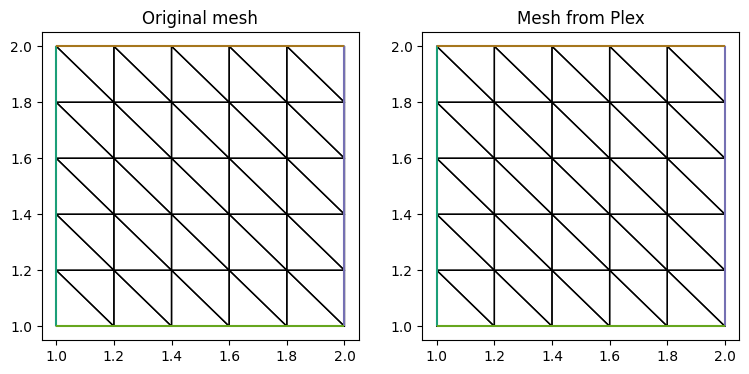

In [16]:
from firedrake import *
from py.update_plex_coordinates import \
    get_plex_with_update_coordinates, \
    get_plex_with_update_coordinates_new
import matplotlib.pyplot as plt

def save_mesh(mesh, name):
    V = FunctionSpace(mesh, 'CG', 1)
    f = Function(V, name='f')
    File(name).write(f)

mesh_init = RectangleMesh(5, 5, 1, 1)

# move mesh
mesh_init.coordinates.dat.data[:] += 1
save_mesh(mesh_init, 'pvd/mesh_init.pvd')

# recreate mesh from the plex
plex = get_plex_with_update_coordinates(mesh_init)
mesh = Mesh(plex, distribution_parameters={"partition": False})
save_mesh(mesh, 'pvd/mesh_with_update_plex.pvd')

fig, ax = plt.subplots(1, 2, figsize=[9, 4], subplot_kw={})
tp0 = triplot(mesh_init, axes=ax[0])
tp1 = triplot(mesh, axes=ax[1])
t0 = ax[0].set_title('Original mesh')
t1 = ax[1].set_title('Mesh from Plex')

### Using adaptMetric of dmplex

File [py/test_adapt_metric.py](py/test_adapt_metric.py)



除了上述 `adaptLabel` 方法, PETSc 还提供的 `adaptMetric` 方法根据用户
提供的度量矩阵对网格进行自适应.

首先使用 `create_metric_from_indicator` 把 `indicator` 转化为度量矩阵 `v`, 然后使用 `to_petsc_local_numbering` 把自由度排序更改为 PETSc 内部序. 注意这里网格每个节点对应一个度量矩阵, 用向量表示.
最后调用 `adaptMetric` 进行自适应网格剖分.

:::{literalinclude} py/test_adapt_metric.py
:pyobject: adapt
:::


方法 `create_metric_from_indicator` 根据输入参数构造度量矩阵, 其思路为先计算各单元的度量矩阵, 然后顶点的度量矩阵通过相邻单元的度量矩阵进行加权平均得到

1. 对单元循环, 求解单元度量矩阵

   :::{literalinclude} py/test_adapt_metric.py
   :linenos:
   :lineno-match:
   :lines: 80-92
   :::

   这里用到了 `edge2vec` 用于根据单元边向量构造计算度量矩阵的矩阵

   :::{literalinclude} py/test_adapt_metric.py
   :linenos:
   :lineno-match:
   :lines: 66-73
   :::

2. 根据单元体积进行加权平均, 计算顶点的度量矩阵

   :::{literalinclude} py/test_adapt_metric.py
   :linenos:
   :lineno-match:
   :lines: 94-96
   :::


方法 `to_petsc_local_numbering` 内容如下

:::{literalinclude} py/test_adapt_metric.py
:pyobject: to_petsc_local_numbering
:::

通过命令行选项或 `OptionsManager`, 我们可以控制使用的自适应库 `pragmatic`, `mmg`, `parmmg`.

:::{literalinclude} py/test_adapt_metric.py
:pyobject: test_adapt
:::

:::{literalinclude} py/test_adapt_metric.py
:pyobject: test_adapt_with_option
:::

下面我们展示一个三维立方体区域自适应的结果

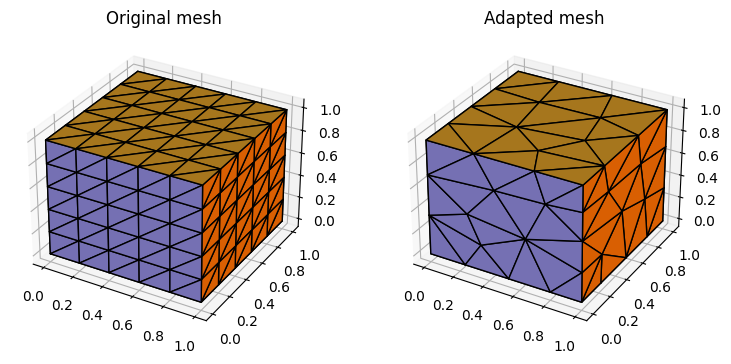

In [17]:
from py.test_adapt_metric import test_adapt, test_adapt_with_option
from firedrake import triplot
import matplotlib.pyplot as plt

mesh, mesh_new = test_adapt_with_option(dim=3, factor=0.3)

if mesh.geometric_dimension() == 3:
    subplot_kw = dict(projection='3d')
else:
    subplot_kw = {}
fig, ax = plt.subplots(1, 2, figsize=[9, 4], subplot_kw=subplot_kw)
tp = triplot(mesh, axes=ax[0])
tp_new = triplot(mesh_new, axes=ax[1])
t0 = ax[0].set_title('Original mesh')
t1 = ax[1].set_title('Adapted mesh')

## Examples on the `variant` parameter for `FiniteElement`

<AxesSubplot: >

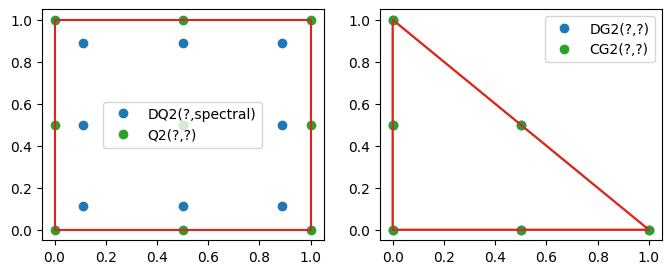

In [18]:
from firedrake import *
import ufl
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


def show_dofs(V, ax=None):
    """Show the position of the nodes in the dual space"""
    if ax is None:
        fig, ax = plt.subplots(figsize=[4, 3])
    ele = V.ufl_element()
    ps = V.finat_element.dual_basis[1]
    ax.plot(ps.points[:, 0], ps.points[:, 1], 'o', label=ele.shortstr())
    cell = V.finat_element.cell
    vertices = np.array(cell.get_vertices())
    hull = ConvexHull(vertices)
    index = list(hull.vertices)
    index.append(index[0])
    ax.plot(vertices[index, 0], vertices[index, 1])
    ax.legend() # (bbox_to_anchor=(1, 1))
    return ax


p = 2 # or set to 3 to make it clear
# https://www.firedrakeproject.org/variational-problems.html#id14
# fe = FiniteElement("DQ", mesh.ufl_cell(), p, variant="equispaced")
mesh = RectangleMesh(1, 1, 1, 1, quadrilateral=True)
fe = FiniteElement("DQ", mesh.ufl_cell(), p, variant="spectral")  # default
V1 = FunctionSpace(mesh, fe)
V2 = FunctionSpace(mesh, 'CG', p)

fig, ax = plt.subplots(1, 2, figsize=[8, 3])
show_dofs(V1, ax=ax[0])
show_dofs(V2, ax=ax[0])

mesh = RectangleMesh(1, 1, 1, 1, quadrilateral=False)
V1 = FunctionSpace(mesh, 'DG', p)
V2 = FunctionSpace(mesh, 'CG', p)
show_dofs(V1, ax=ax[1])
show_dofs(V2, ax=ax[1])


## Interpolation errors for highly oscillating functions

The linear interpolation error of functions with wave number $k$ is

$$ \|I_h f - f\|_{H^1} \le Chk\|f\|_{H^1} $$

In [19]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

def get_H1_expr(e):
    return (inner(e, e) + inner(grad(e), grad(e)))*dx

N = 64
mesh = RectangleMesh(N, N, 1, 1)
h = 1/N

x = SpatialCoordinate(mesh)
k = Constant(1)
f = cos(k*sqrt(dot(x,x)))

p = 1
V = FunctionSpace(mesh, 'CG', p)
V_ref = FunctionSpace(mesh, 'CG', p+2)

Int = Interpolator(f, V)
Int_ref = Interpolator(f, V_ref)

f_int = Function(V)
f_ref = Function(V_ref)

e = f_int - f
e_ref = f_int - f_ref

f_H1 = get_H1_expr(f)
f_ref_H1 = get_H1_expr(f_ref)
f_int_H1 = get_H1_expr(f_int)
e_H1 = get_H1_expr(e)
e_ref_H1 = get_H1_expr(e_ref)

ks = np.linspace(0, 1000, 200) 
errors = np.zeros((len(ks), 2))

dtype = np.dtype([
    ('k', 'f8'),
    ('f_H1', 'f8'),
    ('f_ref_H1', 'f8'),
    ('f_int_H1', 'f8'),
    ('e_H1', 'f8'),
    ('e_ref_H1', 'f8'),
])

ret = np.zeros(len(ks), dtype=dtype)

for i, _k in enumerate(ks):
    k.assign(_k)
    Int.interpolate(output=f_int)
    Int_ref.interpolate(output=f_ref)
    a = sqrt(assemble(f_H1)), sqrt(assemble(f_ref_H1)), sqrt(assemble(f_int_H1))
    b = sqrt(assemble(e_H1)), sqrt(assemble(e_ref_H1))
    ret[i] = (_k, *a, *b)

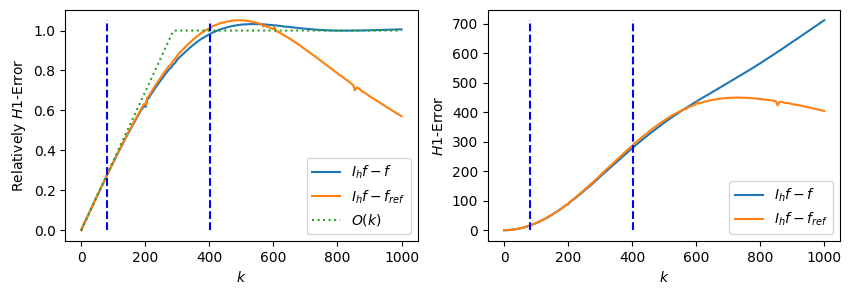

In [20]:
fig, axes = plt.subplots(1, 2, figsize=[10, 3])
e_H1_rel = ret['e_H1']/ret['f_H1']
e_ref_H1_rel = ret['e_ref_H1']/ret['f_H1']
axes[0].plot(ret['k'], e_H1_rel, label='$I_h f - f$')
axes[0].plot(ret['k'], e_ref_H1_rel, label='$I_h f - f_{ref}$')

ref_line = e_H1_rel[10]*ret['k']/ret['k'][10]
ref_line[ref_line>1] = 1
axes[0].plot(ret['k'], ref_line, ':', label='$O(k)$')

upper = max(e_H1_rel.max(), e_ref_H1_rel.max())
for n in (1, 5):
    k_max = 2*pi/(n*h)
    axes[0].plot([k_max, k_max], [0, upper], 'b--')
axes[0].set_xlabel('$k$')
axes[0].set_ylabel('Relatively $H1$-Error')
axes[0].legend()

axes[1].plot(ret['k'], ret['e_H1'], label='$I_h f - f$')
axes[1].plot(ret['k'], ret['e_ref_H1'], label='$I_h f - f_{ref}$')
upper = max(ret['e_H1'].max(), ret['e_ref_H1'].max())
for n in (1, 5):
    k_max = 2*pi/(n*h)
    axes[1].plot([k_max, k_max], [0, upper], 'b--')
axes[1].set_xlabel('$k$')
axes[1].set_ylabel('$H1$-Error')
axes[1].legend()

# axes[0].set_xlim([0, 50])
# axes[0].set_ylim([0, 0.4])
# axes[1].set_xlim([-10, 50])